In [ ]:
!pip install eland
!pip install elasticsearch_dsl

     |████████████████████████████████| 122kB 16.8MB/s 
     |████████████████████████████████| 337kB 34.8MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 


In [ ]:
# Importing Eland and low-level Elasticsearch clients for comparison
import eland as ed
from eland.conftest import *
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q

# Import pandas and numpy for data wrangling
import pandas as pd
import numpy as np

# For pretty-printing
import json

In [ ]:
#Load elastic cloud ID
with open('password.txt') as f:
    ELASTIC_CLOUD_PASSWORD = f.read()
ELASTIC_CLOUD_ID = 'ELAND:dXMtd2VzdDEuZ2NwLmNsb3VkLmVzLmlvJDI3YzgyZGUyZTcyMzQ2OGM5NzhiMTAxYTNiMzFkOWIzJDlhM2NlZDM4NmI3YTQwNGJhYjM3ZjQ5Njc3MWRiMmRi'
    

In [ ]:
# Standard imports
import eland as ed
import pandas as pd
import numpy as np
from elasticsearch import Elasticsearch

# Function for pretty-printing JSON
def json(x):
    import json
    print(json.dumps(x, indent=2, sort_keys=True))

In [ ]:
# Connect to an Elastic Cloud instance
# or another Elasticsearch index below

es = Elasticsearch(
  cloud_id=ELASTIC_CLOUD_ID,
  http_auth=("elastic", ELASTIC_CLOUD_PASSWORD)
)
json(es.info())

{
  "cluster_name": "27c82de2e723468c978b101a3b31d9b3",
  "cluster_uuid": "xcEz2KguTSKWKyWXNmG8Qg",
  "name": "instance-0000000001",
  "tagline": "You Know, for Search",
  "version": {
    "build_date": "2021-03-18T06:17:15.410153305Z",
    "build_flavor": "default",
    "build_hash": "78722783c38caa25a70982b5b042074cde5d3b3a",
    "build_snapshot": false,
    "build_type": "docker",
    "lucene_version": "8.8.0",
    "minimum_index_compatibility_version": "6.0.0-beta1",
    "minimum_wire_compatibility_version": "6.8.0",
    "number": "7.12.0"
  }
}


In [ ]:
# Load the dataset from NYC Open Data and take a look
pd_df = pd.read_csv("rolando.csv").dropna()
pd_df.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 365792 entries, 0 to 394127
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CAMIS             365792 non-null  int64  
 1   DBA               365792 non-null  object 
 2   BORO              365792 non-null  object 
 3   BUILDING          365792 non-null  object 
 4   STREET            365792 non-null  object 
 5   ZIPCODE           365792 non-null  float64
 6   PHONE             365792 non-null  object 
 7   ACTION            365792 non-null  object 
 8   SCORE             365792 non-null  float64
 9   Latitude          365792 non-null  float64
 10  Longitude         365792 non-null  float64
 11  Community Board   365792 non-null  float64
 12  Council District  365792 non-null  float64
 13  Census Tract      365792 non-null  float64
 14  BIN               365792 non-null  float64
 15  BBL               365792 non-null  float64
 16  NTA               36

In [ ]:
# Rename the columns to be snake_case
pd_df.columns = [x.lower().replace(" ", "_") for x in pd_df.columns]

# Combine the 'latitude' and 'longitude' columns into one column 'location' for 'geo_point'
pd_df["location"] = pd_df[["latitude", "longitude"]].apply(lambda x: ",".join(str(item) for item in x), axis=1)

# Drop the old columns in favor of 'location'
pd_df.drop(["latitude", "longitude"], axis=1, inplace=True)

pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365792 entries, 0 to 394127
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   camis             365792 non-null  int64  
 1   dba               365792 non-null  object 
 2   boro              365792 non-null  object 
 3   building          365792 non-null  object 
 4   street            365792 non-null  object 
 5   zipcode           365792 non-null  float64
 6   phone             365792 non-null  object 
 7   action            365792 non-null  object 
 8   score             365792 non-null  float64
 9   community_board   365792 non-null  float64
 10  council_district  365792 non-null  float64
 11  census_tract      365792 non-null  float64
 12  bin               365792 non-null  float64
 13  bbl               365792 non-null  float64
 14  nta               365792 non-null  object 
 15  location          365792 non-null  object 
dtypes: float64(7), int64

In [ ]:
df = ed.pandas_to_eland(
    pd_df=pd_df,
    es_client=es,

    # Where the data will live in Elasticsearch
    es_dest_index="nyc-restaurants",

    # Type overrides for certain columns, 'location' detected
    # automatically as 'keyword' but we want these interpreted as 'geo_point'.
    es_type_overrides={
        "location": "geo_point",
        "dba": "text",
        "zipcode": "short"
    },

    # If the index already exists what should we do?
    es_if_exists="replace",

    # Wait for data to be indexed before returning
    es_refresh=True,
)
df.info()

<class 'eland.dataframe.DataFrame'>
Index: 365792 entries, 26587 to 393208
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   action            365792 non-null  object 
 1   bbl               365792 non-null  float64
 2   bin               365792 non-null  float64
 3   boro              365792 non-null  object 
 4   building          365792 non-null  object 
 5   camis             365792 non-null  int64  
 6   census_tract      365792 non-null  float64
 7   community_board   365792 non-null  float64
 8   council_district  365792 non-null  float64
 9   dba               365792 non-null  object 
 10  location          365792 non-null  object 
 11  nta               365792 non-null  object 
 12  phone             365792 non-null  object 
 13  score             365792 non-null  float64
 14  street            365792 non-null  object 
 15  zipcode           365792 non-null  int64  
dtypes: float64(6), int64(2)

In [ ]:
json(es.indices.get_mapping(index="nyc-restaurants"))


{
  "nyc-restaurants": {
    "mappings": {
      "properties": {
        "action": {
          "type": "keyword"
        },
        "bbl": {
          "type": "double"
        },
        "bin": {
          "type": "double"
        },
        "boro": {
          "type": "keyword"
        },
        "building": {
          "type": "keyword"
        },
        "camis": {
          "type": "long"
        },
        "census_tract": {
          "type": "double"
        },
        "community_board": {
          "type": "double"
        },
        "council_district": {
          "type": "double"
        },
        "dba": {
          "fields": {
            "keyword": {
              "type": "keyword"
            }
          },
          "type": "text"
        },
        "location": {
          "type": "geo_point"
        },
        "nta": {
          "type": "keyword"
        },
        "phone": {
          "type": "keyword"
        },
        "score": {
          "type": "double"
        },
 

In [ ]:
# Shape is determined by using count API
df.shape

(365792, 16)

In [ ]:
# DataFrame has many APIs compatible with Pandas

#df.head(10)
#df.columns
df.dba
#df["grade"]
#df[df.grade.isin(["A", "B"])]
#print(df[df.score.isin(["A", "B"])].es_info())
#print(df.tail(10).es_info())

5419      BUDDHA BODAI ONE VEGETARIAN RESTAURANT
5406                       LAS PALMAS RESTAURANT
5420                                 EAT ITALIAN
5408                                LADUREE SOHO
5422                                 EAT ITALIAN
                           ...                  
393204                      EMPANADAS MONUMENTAL
393205                       LEANLY CHINESE FOOD
393206                       LEANLY CHINESE FOOD
393207                       LEANLY CHINESE FOOD
393208                       LEANLY CHINESE FOOD
Name: dba, Length: 365792, dtype: object

In [ ]:
# Aggregating values
df.describe()

,bbl,bin,...,score,zipcode
count,3.657920e+05,3.657920e+05,...,365792.000000,365792.000000
mean,2.448504e+09,2.510573e+06,...,20.125364,10677.396898
std,1.312592e+09,1.350022e+06,...,14.724959,595.785603
min,1.000000e+09,1.000000e+06,...,-1.000000,10000.000000
25%,1.011196e+09,1.042990e+06,...,11.000000,10022.000000
50%,3.003593e+09,3.007535e+06,...,15.000000,10468.110742
75%,4.002990e+09,4.002443e+06,...,25.866637,11228.835157
max,5.270001e+09,5.799501e+06,...,164.000000,12345.000000


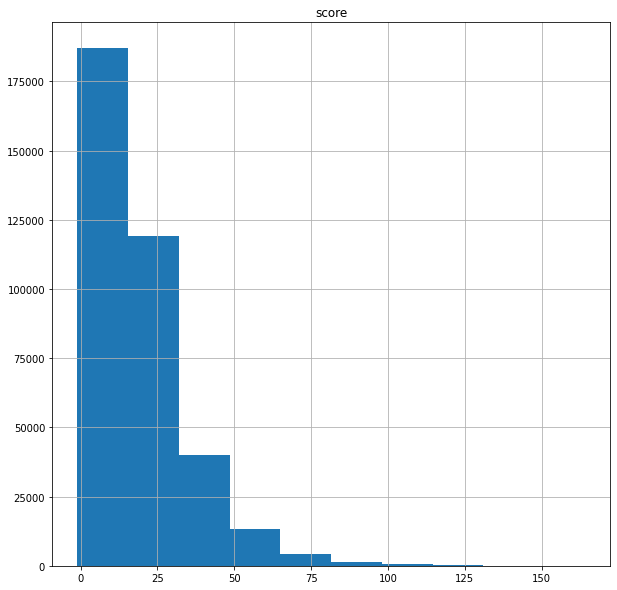

In [ ]:
# Plotting with matplotlib
from matplotlib import pyplot as plt

df[["score"]].hist(figsize=[10,10])
plt.show()

In [ ]:
# es_query() allows for the full Elasticsearch querying capabilities
df.es_query({
  "geo_distance": {
    "distance": "50m",
    "location": {
      "lat": 40.643852716573,
      "lon": -74.011628212186
    }
  }
})

,action,bbl,...,street,zipcode
27616,8,3.008080e+09,...,5 AVENUE,11220.0
27617,8,3.008080e+09,...,5 AVENUE,11220.0
37083,D,3.008080e+09,...,5 AVENUE,11220.0
37084,D,3.008080e+09,...,5 AVENUE,11220.0
37085,D,3.008080e+09,...,5 AVENUE,11220.0
...,...,...,...,...,...
294554,D,3.008080e+09,...,5 AVENUE,11220.0
294555,D,3.008080e+09,...,5 AVENUE,11220.0
303637,D,3.008080e+09,...,5 AVENUE,11220.0
311039,D,3.008070e+09,...,5 AVENUE,11220.0


In [ ]:
# Pull a subset of your data for building graphs / operations locally.
sample_df = df[df.score == "B"].sample(100).to_pandas()
sample_df.info()
print(type(sample_df))

In [ ]:
# Import scikit-learn and train a dataset locally
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier

# Train the data locally
digits = datasets.load_wine()
print("Feature Names:", digits.feature_names)
print("Data example:", digits.data[0])

# Save 10, 80, and 140 for testing our model
data = [x for i, x in enumerate(digits.data) if i not in (10, 80, 140)]
target = [x for i, x in enumerate(digits.target) if i not in (10, 80, 140)]

sk_classifier = DecisionTreeClassifier()
sk_classifier.fit(data, target)

# Test out our model against the three targets
print(sk_classifier.predict(digits.data[[10, 80, 140]]))
print(digits.target[[10, 80, 140]])

Feature Names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Data example: [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
[0 1 2]
[0 1 2]


In [ ]:
from eland.ml import MLModel

# Serialize the scikit-learn model into Elasticsearch
ed_classifier = MLModel.import_model(
  es_client=es,
  model_id="wine-classifier",
  model=sk_classifier,
  feature_names=digits.feature_names,
  
)

# Capture the Elasticsearch API call w/ logging
import logging
logger = logging.getLogger("elasticsearch")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

# Use the same data as before, but now with the model in Elasticsearch
print(ed_classifier.predict(digits.data[[10, 80, 140]].tolist()))
print(digits.target[[10, 80, 140]])

logger.handlers = []

ValueError: ignored

In [ ]:
json({"pipeline":{"processors":[{"inference":{"model_id":"wine-classifier","inference_config":{"classification":{}},"field_map":{}}}]},"docs":[{"_source":{"alcohol":14.1,"malic_acid":2.16,"ash":2.3,"alcalinity_of_ash":18.0,"magnesium":105.0,"total_phenols":2.95,"flavanoids":3.32,"nonflavanoid_phenols":0.22,"proanthocyanins":2.38,"color_intensity":5.75,"hue":1.25,"od280/od315_of_diluted_wines":3.17,"proline":1510.0}},{"_source":{"alcohol":12.0,"malic_acid":0.92,"ash":2.0,"alcalinity_of_ash":19.0,"magnesium":86.0,"total_phenols":2.42,"flavanoids":2.26,"nonflavanoid_phenols":0.3,"proanthocyanins":1.43,"color_intensity":2.5,"hue":1.38,"od280/od315_of_diluted_wines":3.12,"proline":278.0}},{"_source":{"alcohol":12.93,"malic_acid":2.81,"ash":2.7,"alcalinity_of_ash":21.0,"magnesium":96.0,"total_phenols":1.54,"flavanoids":0.5,"nonflavanoid_phenols":0.53,"proanthocyanins":0.75,"color_intensity":4.6,"hue":0.77,"od280/od315_of_diluted_wines":2.31,"proline":600.0}}]})


{
  "docs": [
    {
      "_source": {
        "alcalinity_of_ash": 18.0,
        "alcohol": 14.1,
        "ash": 2.3,
        "color_intensity": 5.75,
        "flavanoids": 3.32,
        "hue": 1.25,
        "magnesium": 105.0,
        "malic_acid": 2.16,
        "nonflavanoid_phenols": 0.22,
        "od280/od315_of_diluted_wines": 3.17,
        "proanthocyanins": 2.38,
        "proline": 1510.0,
        "total_phenols": 2.95
      }
    },
    {
      "_source": {
        "alcalinity_of_ash": 19.0,
        "alcohol": 12.0,
        "ash": 2.0,
        "color_intensity": 2.5,
        "flavanoids": 2.26,
        "hue": 1.38,
        "magnesium": 86.0,
        "malic_acid": 0.92,
        "nonflavanoid_phenols": 0.3,
        "od280/od315_of_diluted_wines": 3.12,
        "proanthocyanins": 1.43,
        "proline": 278.0,
        "total_phenols": 2.42
      }
    },
    {
      "_source": {
        "alcalinity_of_ash": 21.0,
        "alcohol": 12.93,
        "ash": 2.7,
        "color_inten

In [ ]:
json({"docs":[{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":14.1,"alcalinity_of_ash":18.0,"proanthocyanins":2.38,"od280/od315_of_diluted_wines":3.17,"total_phenols":2.95,"magnesium":105.0,"flavanoids":3.32,"proline":1510.0,"malic_acid":2.16,"ash":2.3,"nonflavanoid_phenols":0.22,"hue":1.25,"color_intensity":5.75,"ml":{"inference":{"predicted_value":"0","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.98965Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.0,"alcalinity_of_ash":19.0,"proanthocyanins":1.43,"od280/od315_of_diluted_wines":3.12,"total_phenols":2.42,"magnesium":86.0,"flavanoids":2.26,"proline":278.0,"malic_acid":0.92,"ash":2.0,"nonflavanoid_phenols":0.3,"hue":1.38,"color_intensity":2.5,"ml":{"inference":{"predicted_value":"1","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.98966Z"}}},{"doc":{"_index":"_index","_type":"_doc","_id":"_id","_source":{"alcohol":12.93,"alcalinity_of_ash":21.0,"proanthocyanins":0.75,"od280/od315_of_diluted_wines":2.31,"total_phenols":1.54,"magnesium":96.0,"flavanoids":0.5,"proline":600.0,"malic_acid":2.81,"ash":2.7,"nonflavanoid_phenols":0.53,"hue":0.77,"color_intensity":4.6,"ml":{"inference":{"predicted_value":"2","model_id":"wine-classifier"}}},"_ingest":{"timestamp":"2020-07-08T15:35:49.989672Z"}}}]})


{
  "docs": [
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
          "timestamp": "2020-07-08T15:35:49.98965Z"
        },
        "_source": {
          "alcalinity_of_ash": 18.0,
          "alcohol": 14.1,
          "ash": 2.3,
          "color_intensity": 5.75,
          "flavanoids": 3.32,
          "hue": 1.25,
          "magnesium": 105.0,
          "malic_acid": 2.16,
          "ml": {
            "inference": {
              "model_id": "wine-classifier",
              "predicted_value": "0"
            }
          },
          "nonflavanoid_phenols": 0.22,
          "od280/od315_of_diluted_wines": 3.17,
          "proanthocyanins": 2.38,
          "proline": 1510.0,
          "total_phenols": 2.95
        },
        "_type": "_doc"
      }
    },
    {
      "doc": {
        "_id": "_id",
        "_index": "_index",
        "_ingest": {
          "timestamp": "2020-07-08T15:35:49.98966Z"
        },
        "_source": {
          "a

In [ ]:
print(df[df["zipcode"] > df["score"]].es_info())


es_index_pattern: nyc-restaurants
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                     es_field_name  is_source   es_dtype es_date_format pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
action                      action       True    keyword           None   object           True             True        False                     action
bbl                            bbl       True     double           None  float64           True             True        False                        bbl
bin                            bin       True     double           None  float64           True             True        False                        bin
boro                          boro       True    keyword           None   object           True             True        False                       boro
building                  building       True    keyword           None   object           True             True        Fals